# Transformer Fundamentals – Guided Notebook 01 — Input Tokens (Tokenization & Embeddings)
**Date:** 2025-10-29
**Style:** Guided, hands-on; from-scratch first, then frameworks; interactive visuals

## Learning Objectives

- Understand subword tokenization (BPE/WordPiece) and why it’s used.
- Map tokens to vectors via embedding tables.
- Visualize token embeddings with [Principal Component Analysis, or PCA](./GLOSSARY.md#pca); explore proximity and analogies.
- Connect toy NumPy embeddings to HF tokenizers and real models (GPT-2, BERT).

## TL;DR

Text → tokens → indices → embedding vectors. Tokenization shapes what the model can represent;
embeddings give each token a learned coordinate in vector space.

## Concept Overview

### Tokenization splits text into subword units to balance vocabulary size and coverage
Language models can’t operate directly on raw text — they need discrete units called *tokens*.
Early systems used full words, but that led to extremely large vocabularies and poor handling of rare or new words.
Modern models instead use **subword tokenization**, such as *Byte Pair Encoding (BPE)* or *WordPiece*, which splits words into smaller chunks like `"play"`, `"##ing"`, `"##ed"`.
This approach strikes a balance between:
- **Coverage:** the ability to represent any input text, including unseen words
- **Compactness:** keeping the vocabulary small enough for efficient training and inference

For example:
> `"playing"` → `["play", "##ing"]`
> `"cats"` → `["cat", "##s"]`

These consistent subword fragments allow the model to generalize across similar forms of words without memorizing every variant.

---

### Each token id indexes into an embedding matrix `E` with shape `[vocab_size, d_model]`
Once tokenized, text becomes a list of integer IDs — each representing a position in the vocabulary.
These IDs map into an **embedding matrix** `E`, a learnable lookup table where each row corresponds to a token’s vector representation.
If your vocabulary has 50,000 tokens and the model’s hidden size (`d_model`) is 768, then `E` has shape `[50000, 768]`.
When the model processes a sentence, it retrieves the embeddings for the tokens it sees:

\[
\text{Embeddings} = E[\text{token\_ids}]
\]

Each token’s embedding acts like its *coordinate* in a high-dimensional semantic space.
During training, these vectors are updated so that tokens appearing in similar contexts end up close to each other in this space.

---

### Similar tokens often cluster in embedding space
Because embeddings capture contextual meaning, similar or related words develop similar vector representations.
For instance:
- `"king"` and `"queen"` end up close together
- `"cat"` and `"dog"` might form a cluster separate from `"car"` or `"tree"`

We can visualize this by projecting embeddings into 2D (e.g., using PCA or UMAP).
You’ll typically see clear groupings: plural forms, verb tenses, or semantically related concepts cluster naturally.

This property makes embeddings useful beyond Transformers — they’re the backbone for many semantic similarity and retrieval systems.

---

**In short:**
Tokenization breaks text into manageable, reusable pieces.
Embeddings turn those pieces into vectors that capture relationships between words.
Together, they form the foundation upon which attention and all subsequent Transformer layers operate.


In [43]:

# %% [setup] Environment check & minimal installs (run once per kernel)
# Target: Python 3.12.12, PyTorch 2.5+, transformers 4.44+, datasets 3+, ipywidgets 8+, matplotlib 3.8+
import sys, platform, subprocess, os

print("Python:", sys.version)
print("Platform:", platform.platform())

# Optional: uncomment to install/upgrade on this machine (internet required)
# !pip install --upgrade pip
# !pip install "torch>=2.5" "transformers>=4.44" "datasets>=3.0.0" "ipywidgets>=8.1.0" "matplotlib>=3.8" "umap-learn>=0.5.6"

try:
    import torch
    print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("CUDA device count:", torch.cuda.device_count())
        print("CUDA device name:", torch.cuda.get_device_name(0))
except Exception as e:
    print("PyTorch not available yet:", e)

%config InlineBackend.figure_format = 'retina'
from IPython.display import display, HTML
try:
    import ipywidgets as widgets
    from ipywidgets import interact, interactive
    print("ipywidgets:", widgets.__version__)
except Exception as e:
    print("ipywidgets not available yet:", e)

import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)


Python: 3.13.5 (main, Jun 25 2025, 18:55:22) [GCC 14.2.0]
Platform: Linux-6.12.48+deb13-amd64-x86_64-with-glibc2.41
Torch: 2.9.0+cu128 | CUDA available: True
CUDA device count: 2
CUDA device name: NVIDIA GeForce RTX 3060
ipywidgets: 8.1.7


### How this toy example relates to real tokenization

In real Transformer models, tokenization is handled by learned algorithms such as **Byte Pair Encoding (BPE)**, **WordPiece**, or **SentencePiece**.
These systems are trained on large corpora to identify the most frequent character sequences, striking a balance between vocabulary size and expressiveness.

Our `toy_tokenize` function mimics that behavior in a simple, rule-based way:
- It detects suffixes like `"s"` and `"ting"` to create *subword* tokens (`"##s"`, `"##ting"`).
- It falls back to `<unk>` (unknown token) for anything not in the small vocabulary.
- It produces token sequences that can be mapped directly to embeddings.

**Conceptually:**
- Each token ID indexes into an embedding matrix — just like our `E` lookup table.
- The embedding matrix is a learnable parameter in real models; ours is randomly initialized.
- During training, real embeddings are adjusted so that semantically related tokens occupy nearby positions in vector space.

This example isolates the *mechanics* of tokenization and embedding lookup
so you can see the process clearly before adding more complex components like attention and feed-forward layers.


In [51]:
# %% [from-scratch] Toy BPE-like tokenization & embeddings (NumPy)
# ---------------------------------------------------------------------
# Purpose:
# This block demonstrates the basic idea of tokenization and embedding lookup
# without relying on external libraries. It uses a tiny hand-crafted vocabulary
# to show how text is split into subword units and mapped into vector space.
# ---------------------------------------------------------------------

# A minimal vocabulary with subword tokens and special tokens.
vocab = {"<pad>":0, "<unk>":1, "the":2, "cat":3, "##s":4, "sat":5, "on":6, "##ting":7, 'fence':8}

# Dimensionality of each token vector (embedding size).
d_model = 8

# Randomly initialized embedding matrix: [vocab_size, d_model]
E = np.random.randn(len(vocab), d_model) * 0.1


def toy_tokenize(text):
    """
    Very simple, rule-based tokenizer for demonstration purposes.

    - Splits text by spaces.
    - Recognizes basic suffix patterns ("s", "ting") and converts them
      into subword tokens (e.g., "cats" → ["cat", "##s"]).
    - Falls back to "<unk>" for unknown words.

    Returns:
        list[str]: tokens recognized in the given text.
    """
    parts = text.lower().split()
    tokens = []
    for w in parts:
        if w in vocab:
            tokens.append(w)
        elif w.endswith("s") and w[:-1] in vocab:
            tokens += [w[:-1], "##s"]
        elif w.endswith("ting") and w[:-5] in vocab:
            tokens += [w[:-5], "##ting"]
        else:
            tokens.append("<unk>")
    return tokens


# Example input text.
text = "The cat sits on the fence because it is warm"

# Tokenize → map to IDs → lookup embeddings.
toks = toy_tokenize(text)
ids = [vocab.get(t, vocab["<unk>"]) for t in toks]
vecs = E[ids]

# Inspect the process.
print("Text:", text)
print("Tokens:", toks)
print("IDs:", ids)
print("Embeddings shape:", vecs.shape)


Text: The cat sits on the fence because it is warm
Tokens: ['the', 'cat', '<unk>', 'on', 'the', 'fence', '<unk>', '<unk>', '<unk>', '<unk>']
IDs: [2, 3, 1, 6, 2, 8, 1, 1, 1, 1]
Embeddings shape: (10, 8)


### Visualizing token embeddings with PCA

Each token’s embedding is an `n`-dimensional vector (in this case, 8D).
Since humans can’t interpret high-dimensional spaces directly, we use **Principal Component Analysis (PCA)** to project these vectors down to two dimensions while preserving as much variance (structure) as possible.

**Principal Components** are the new coordinate axes that capture the directions
of greatest variance in the data.
- The **first principal component (PC1)** explains the largest amount of variation.
- The **second principal component (PC2)** explains the next largest amount, orthogonal to the first.
By plotting embeddings along these top components, we can see the dominant patterns
of how tokens differ from each other.

If the embeddings were trained (not random), you would expect:
- **Similar tokens** (like `"cat"` and `"##s"`) to appear **closer together**.
- **Unrelated tokens** (like `"on"` or `"sat"`) to appear further apart.

This type of visualization helps us *see* how the model encodes relationships between words — a first glimpse into the geometry of meaning within embedding space.


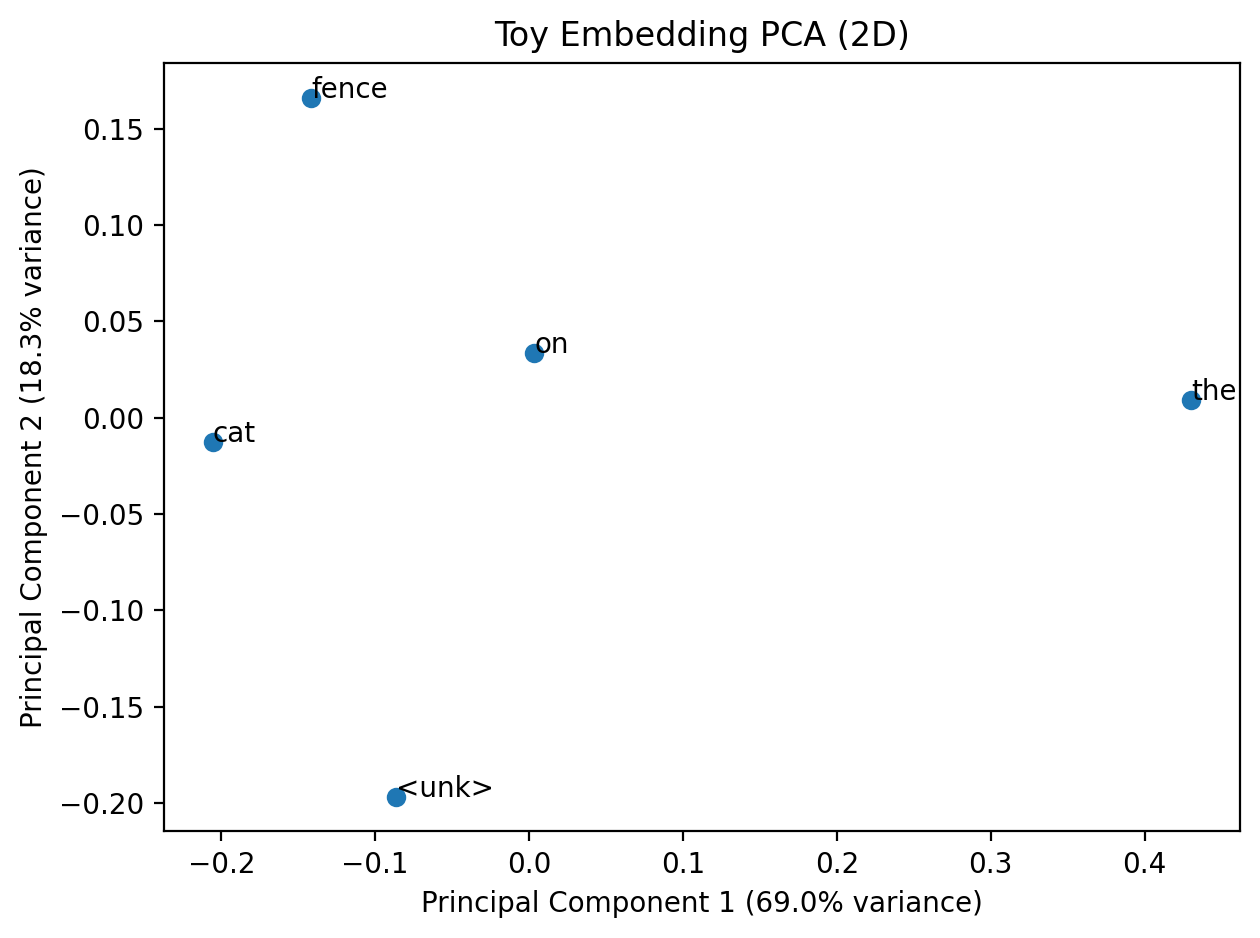

In [52]:
# %% [visualize] PCA projection of embeddings of unique tokens in this sentence
# ---------------------------------------------------------------------
# Purpose:
# This section visualizes how the embedding vectors for different tokens
# relate to each other in space. Although our embeddings are random, this
# demonstrates how dimensionality reduction (PCA) can reveal structure
# in learned embeddings.
# ---------------------------------------------------------------------

from sklearn.decomposition import PCA

# Select unique token IDs from the current sentence.
unique_ids = sorted(set(ids))

# Retrieve their embedding vectors from the matrix E.
X = E[unique_ids]

# Reduce embedding dimensionality from d_model → 2D for visualization.
pca = PCA(n_components=2).fit(X)
X2 = pca.transform(X)
explained = pca.explained_variance_ratio_ * 100  # percentage of variance per component

# Plot each token as a point in 2D space, with text labels.
plt.figure()
plt.scatter(X2[:, 0], X2[:, 1])
for i, tid in enumerate(unique_ids):
    token = list(vocab.keys())[list(vocab.values()).index(tid)]
    plt.text(X2[i, 0], X2[i, 1], token)

# Add title and axis labels showing explained variance
plt.title("Toy Embedding PCA (2D)")
plt.xlabel(f"Principal Component 1 ({explained[0]:.1f}% variance)")
plt.ylabel(f"Principal Component 2 ({explained[1]:.1f}% variance)")
plt.tight_layout()
plt.show()


### Comparing real tokenizers and embeddings

This block moves from our toy example to real-world Transformer models hosted on the **Hugging Face Hub**.
Each model comes with its own tokenizer and learned embedding table.

- **Tokenizer:** Handles text normalization, subword segmentation, and mapping to IDs.
  - *GPT-2* uses Byte Pair Encoding (BPE).
  - *BERT* uses WordPiece with lowercase normalization (`bert-base-uncased`).

- **Embedding Matrix:** A learned lookup table that converts token IDs into dense vectors.
  - Shape: `[vocab_size, hidden_dim]` (e.g., 50,257 × 768 for GPT-2).

You may notice that GPT-2’s tokens often begin with the special character **`Ġ`**.
This symbol isn’t part of normal text—it’s how GPT-2’s byte-level tokenizer marks a **leading space**.
For example, `" quick"` becomes `"Ġquick"`, while a word at the start of a sentence like `"The"` remains `"The"`.
BERT, by contrast, doesn’t encode spaces this way—it uses prefixes like `##` to indicate subword continuations
(e.g., `"playing"` → `"play"`, `"##ing"`).

By examining both GPT-2 and BERT:
- You see how different architectures tokenize the *same* sentence in distinct ways.
- You confirm that embedding size (`hidden_dim`) determines the model’s representational capacity.

This bridges your conceptual foundation — tokenization and embeddings — to real, deployed Transformer architectures.


In [46]:
# %% [framework] Hugging Face tokenizers & model embeddings
# ---------------------------------------------------------------------
# Purpose:
# This section connects our toy example to real, pretrained Transformer models
# from Hugging Face. It shows how tokenization and embeddings are implemented
# in production-grade architectures like GPT-2 and BERT.
# ---------------------------------------------------------------------

from transformers import AutoTokenizer, AutoModel

# Define a few representative models:
# - GPT-2 (decoder-only, autoregressive)
# - BERT (encoder-only, bidirectional)
model_names = {
    "gpt2": "gpt2",
    "bert": "bert-base-uncased"
}

# Loop over each model to inspect its tokenizer and embedding layer.
for label, m in model_names.items():
    print(f"--- {label.upper()} ---")

    # Load the pretrained tokenizer.
    tok = AutoTokenizer.from_pretrained(m)

    # Example sentence to tokenize.
    sample = "The quick brown fox jumps over the lazy dog."

    # Perform tokenization and convert tokens to integer IDs.
    toks = tok.tokenize(sample)
    ids = tok.encode(sample, add_special_tokens=True)

    print("Tokens:", toks)
    print("IDs:", ids[:12], "...")

    # Load the pretrained model (weights downloaded automatically).
    mdl = AutoModel.from_pretrained(m)

    # Retrieve the learned embedding matrix (as a NumPy array).
    emb = mdl.get_input_embeddings().weight.detach().cpu().numpy()

    # Display its shape: [vocab_size, hidden_dim]
    print("Embedding matrix shape:", emb.shape)


--- GPT2 ---
Tokens: ['The', 'Ġquick', 'Ġbrown', 'Ġfox', 'Ġjumps', 'Ġover', 'Ġthe', 'Ġlazy', 'Ġdog', '.']
IDs: [464, 2068, 7586, 21831, 18045, 625, 262, 16931, 3290, 13] ...
Embedding matrix shape: (50257, 768)
--- BERT ---
Tokens: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.']
IDs: [101, 1996, 4248, 2829, 4419, 14523, 2058, 1996, 13971, 3899, 1012, 102] ...
Embedding matrix shape: (30522, 768)


### Visualizing real learned embeddings with PCA

Now that we’ve inspected how tokenization and embedding lookup work in real models,
let’s project a few **actual embeddings** from a pretrained model into 2D space.

Unlike our toy example (where embeddings were random), these vectors have been
**learned through training** — tokens with related meanings (like *king* and *queen*)
should appear closer together in this projection.


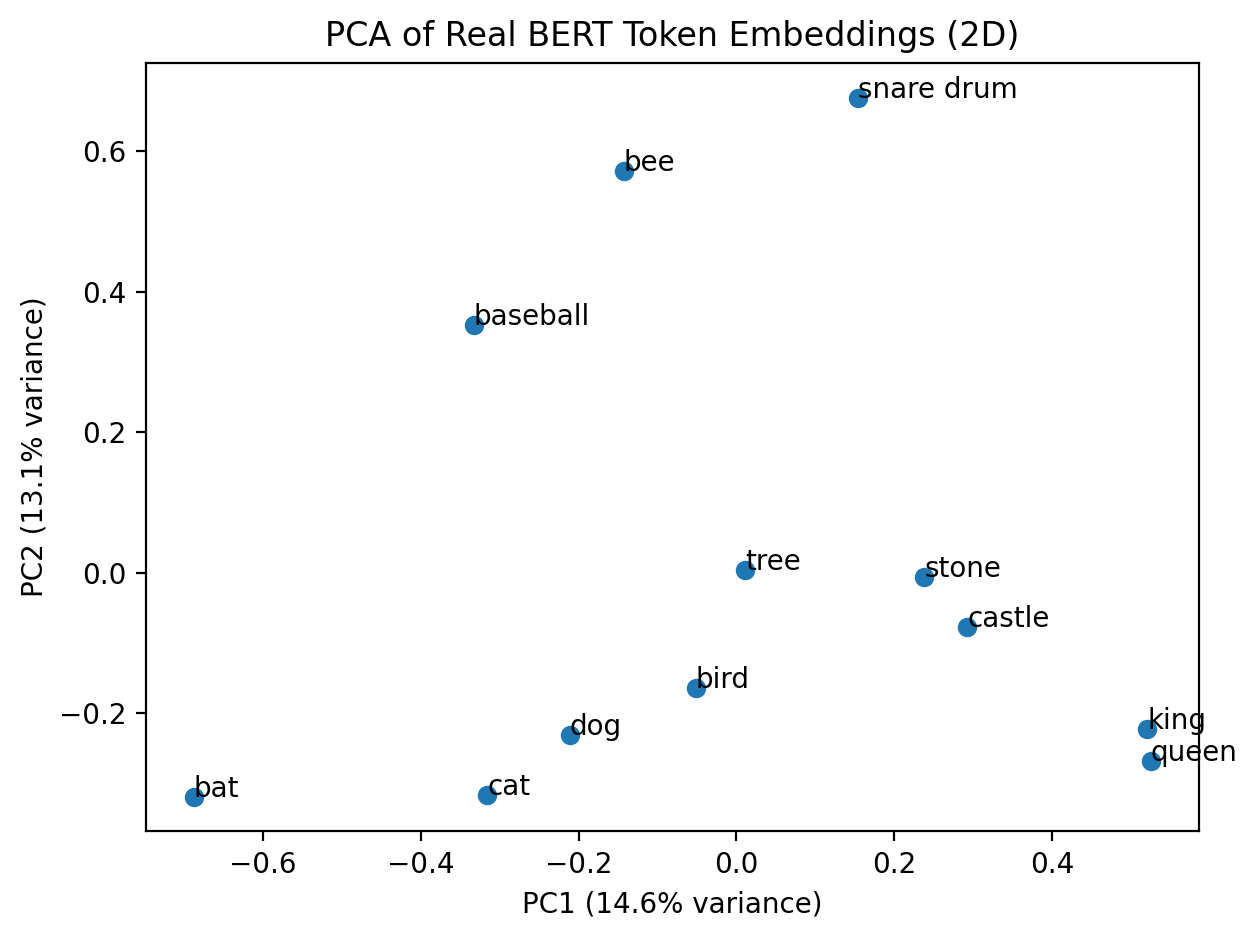

In [49]:
# %% [visualize] PCA of real embeddings for selected tokens
# ---------------------------------------------------------------------
# Purpose:
# Visualize a small set of *real* learned token embeddings from a pretrained
# BERT model. Unlike our toy embeddings, these vectors have been shaped by
# large-scale training, so semantically related words tend to cluster.
# ---------------------------------------------------------------------

from sklearn.decomposition import PCA

# Choose a few semantically distinct tokens to compare.
selected_tokens = ["cat", "dog", "tree", "king", "queen", "bee", "bat", "baseball", "bird", "stone", "castle", "snare drum"]

# Load tokenizer and model (weights automatically cached by Hugging Face).
tok = AutoTokenizer.from_pretrained("bert-base-uncased")
mdl = AutoModel.from_pretrained("bert-base-uncased")

# Get the embedding layer (matrix of shape [vocab_size, hidden_dim]).
emb = mdl.get_input_embeddings()

# Collect the embedding vectors for each selected token.
vecs = []
for t in selected_tokens:
    tid = tok.convert_tokens_to_ids(t)
    vecs.append(emb.weight[tid].detach().cpu().numpy())

# Reduce from hidden_dim (e.g., 768D) to 2D using PCA for visualization.
pca = PCA(n_components=2)
X2 = pca.fit_transform(vecs)

# Plot the projected embeddings in 2D with text labels.
plt.figure()
plt.scatter(X2[:, 0], X2[:, 1])
for i, t in enumerate(selected_tokens):
    plt.text(X2[i, 0], X2[i, 1], t)

# Add title and variance-based axis labels for context.
plt.title("PCA of Real BERT Token Embeddings (2D)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.tight_layout()
plt.show()



---
### Bonus: Multilingual Extension
- Swap the tokenizer/model for a multilingual variant (e.g., `bert-base-multilingual-cased` or `xlm-roberta-base`).
- Repeat a small slice of the notebook (tokenization, attention map) on non-English sentences and compare.


In [53]:
# %% [bonus] Multilingual tokenization comparison
# ---------------------------------------------------------------------
# Purpose:
# Explore how multilingual models handle non-English text by comparing
# tokenization between English and another language (e.g., Spanish).
# ---------------------------------------------------------------------

from transformers import AutoTokenizer

# Choose a multilingual model (supports 100+ languages)
multi_model = "bert-base-multilingual-cased"
tok = AutoTokenizer.from_pretrained(multi_model)

# Example sentences in English and Spanish (you can substitute any languages)
examples = {
    "English": "The quick brown fox jumps over the lazy dog.",
    "Spanish": "El rápido zorro marrón salta sobre el perro perezoso.",
    "French": "Le renard brun rapide saute par-dessus le chien paresseux.",
    "Russian": "Быстрая коричневая лисица перепрыгивает через ленивую собаку.",
    "Japanese": "素早い茶色の狐が怠け者の犬を飛び越える。",
    "Chinese": "敏捷的棕色狐狸跳过那只懒狗。",
    "Korean": "빠른 갈색 여우가 게으른 개를 뛰어넘는다."
}

for lang, text in examples.items():
    tokens = tok.tokenize(text)
    ids = tok.encode(text, add_special_tokens=True)
    print(f"--- {lang} ---")
    print("Text:", text)
    print("Tokens:", tokens)
    print("IDs:", ids[:12], "...")
    print()


--- English ---
Text: The quick brown fox jumps over the lazy dog.
Tokens: ['The', 'quick', 'brown', 'f', '##ox', 'jump', '##s', 'over', 'the', 'la', '##zy', 'dog', '.']
IDs: [101, 10117, 69609, 31299, 174, 31978, 54941, 10107, 10491, 10105, 10109, 12547] ...

--- Spanish ---
Text: El rápido zorro marrón salta sobre el perro perezoso.
Tokens: ['El', 'rápido', 'zo', '##rro', 'marrón', 'salt', '##a', 'sobre', 'el', 'per', '##ro', 'per', '##ez', '##oso', '.']
IDs: [101, 10224, 40625, 12555, 38692, 102521, 44253, 10113, 10690, 10125, 10178, 10567] ...

--- French ---
Text: Le renard brun rapide saute par-dessus le chien paresseux.
Tokens: ['Le', 'ren', '##ard', 'brun', 'rapide', 'saut', '##e', 'par', '-', 'dessus', 'le', 'chien', 'pares', '##se', '##ux', '.']
IDs: [101, 10281, 63256, 13167, 65352, 45420, 98995, 10112, 10248, 118, 29272, 10141] ...

--- Russian ---
Text: Быстрая коричневая лисица перепрыгивает через ленивую собаку.
Tokens: ['Б', '##ыс', '##тра', '##я', 'кор', '##ичне', '##в

---
## Reflection & Next Steps
- How did the tokenizer break your sample text into subword units?
  Did anything surprise you about how words were split?
- What patterns did you notice in the embedding visualizations — even with random vs. real embeddings?
- Try experimenting with your own text to see how different tokenizers handle punctuation, casing, and rare words.
- Explore other pretrained models (e.g., RoBERTa, DistilBERT) and compare their embedding dimensions and vocab sizes.
- Save or screenshot a PCA plot that you feel best illustrates how tokens relate in embedding space.
